In [26]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris, load_digits, fetch_openml
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer, KBinsDiscretizer, Binarizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
from dl85 import DL85Boostera
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import subprocess

depth, time_limit, N_FOLDS = 2, 0, 5

# dataset = np.genfromtxt("../datasets/paper_test.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/zoo-1.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/kr-vs-kp.txt", delimiter=" ")
dataset = np.genfromtxt("../datasets/tic-tac-toe.txt", delimiter=" ")
X, y = dataset[:, 1:], dataset[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=50)
start = time.perf_counter()
print("Model building...")
clf.fit(X_train, y_train)

#np.histogram(margins)

Model building...


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

DescribeResult(nobs=766, minmax=(-0.19999999999999998, 0.4000000000000001), mean=0.1283028720626632, variance=0.011967573508080344, skewness=-0.06042778993911322, kurtosis=-0.22044254468544722)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


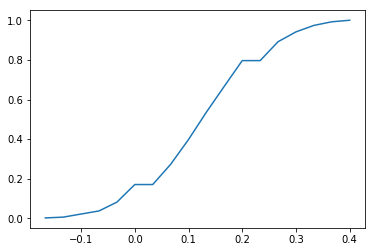

In [60]:
import matplotlib.pyplot as plt
from scipy import stats



sw = sum(clf.estimator_weights_)

pred = np.array([-clf.estimator_weights_[0]/sw if p != y_train[i] else clf.estimator_weights_[0]/sw for i, p in enumerate(clf.estimators_[0].predict(X_train))])
margins = pred.reshape((-1, 1))

for i in range(1, len(clf.estimators_)):
    pred = np.array([-clf.estimator_weights_[i]/sw if p != y_train[j] else clf.estimator_weights_[i]/sw for j, p in enumerate(clf.estimators_[i].predict(X_train))])
    margins = np.concatenate((margins, pred.reshape(-1, 1)), axis=1)

marginss = np.sum(margins, axis=1)

marginss = np.sum(margins, axis=1)
#plt.hist(marginss, bins='auto')
#print(stats.describe(marginss))
hx, hy = np.histogram(marginss, bins='auto', normed=1)
dx = hy[1] - hy[0]
F1 = np.cumsum(hx)*dx
plt.plot(hy[1:], F1)
print(stats.describe(marginss))

#X2 = np.sort(marginss)
#F2 = np.array(range(len(marginss)))/float(len(marginss))
#F2 = 1. * np.arange(len(marginss)) / (len(margins) - 1)
#plt.plot(X2, F2)

#from scipy.stats import norm
#x = np.linspace(-1,1,len(marginss))
#y = norm.cdf(marginss)
#plt.plot(marginss, y)

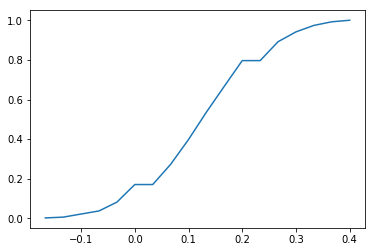

In [36]:
plt.plot(hy[1:], F1)

DescribeResult(nobs=192, minmax=(-2.0, 2.0), mean=0.4479166666666667, variance=1.7878490401396159, skewness=-0.290109658706218, kurtosis=-0.797064615229707)


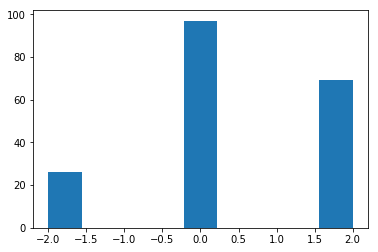

In [16]:
import matplotlib.pyplot as plt
from scipy import stats

marginss = np.sum(margins[:,:2], axis=1)
plt.hist(marginss, bins='auto')
print(stats.describe(marginss))

In [28]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris, load_digits, fetch_openml
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer, KBinsDiscretizer, Binarizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
from dl85 import DL85Boostera
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import subprocess

depth, time_limit, N_FOLDS = 2, 0, 5

# dataset = np.genfromtxt("../datasets/paper_test.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/zoo-1.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/kr-vs-kp.txt", delimiter=" ")
dataset = np.genfromtxt("../datasets/tic-tac-toe.txt", delimiter=" ")
X, y = dataset[:, 1:], dataset[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf1 = DL85Boostera(max_depth=depth, max_iterations=50)
start = time.perf_counter()
print("Model building...")
clf1.fit(X_train, y_train)

Model building...


DL85Boostera(asc=False, base_estimator=None, desc=False, error_function=None,
             fast_error_function=None, gamma=None, iterative=False, max_depth=2,
             max_error=0, max_iterations=50, min_sup=1, model='cvxpy',
             opti_gap=1e-05, print_output=False, quiet=True, regulator=5,
             repeat_sort=False, stop_after_better=False, time_limit=0,
             verbose=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]


DescribeResult(nobs=766, minmax=(-0.22706942489476117, 0.6286075363685514), mean=0.20870882760621917, variance=0.020765194926594666, skewness=-0.19005682847838698, kurtosis=-0.2241130223084613)


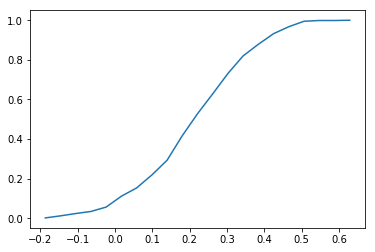

In [61]:
import matplotlib.pyplot as plt
from scipy import stats

sw = sum(clf1.estimator_weights_)
margins = None

for i in range(len(clf1.estimators_)):
    pred = np.array([-clf1.estimator_weights_[i]/sw if p != y_train[j] else clf1.estimator_weights_[i]/sw for j, p in enumerate(clf1.estimators_[i].predict(X_train))])
    margins = np.concatenate((margins, pred.reshape(-1, 1)), axis=1) if margins is not None else pred.reshape((-1, 1))

marginss = np.sum(margins, axis=1)

hx, hy = np.histogram(marginss, bins='auto', normed=1)
dx = hy[1] - hy[0]
F1 = np.cumsum(hx)*dx
plt.plot(hy[1:], F1)
print(stats.describe(marginss))

#np.histogram(margins)
#marginss = np.sum(margins, axis=1)
#plt.hist(marginss, bins='auto')
#print(stats.describe(marginss))

In [31]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris, load_digits, fetch_openml
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer, KBinsDiscretizer, Binarizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
from dl85 import DL85Boostera
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import subprocess

depth, time_limit, N_FOLDS = 2, 0, 5

# dataset = np.genfromtxt("../datasets/paper_test.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/zoo-1.txt", delimiter=" ")
# dataset = np.genfromtxt("../datasets/kr-vs-kp.txt", delimiter=" ")
dataset = np.genfromtxt("../datasets/tic-tac-toe.txt", delimiter=" ")
X, y = dataset[:, 1:], dataset[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf2 = DL85Boostera(max_depth=depth, max_iterations=50, regulator=0.01)
start = time.perf_counter()
print("Model building...")
clf2.fit(X_train, y_train)

Model building...


DL85Boostera(asc=False, base_estimator=None, desc=False, error_function=None,
             fast_error_function=None, gamma=None, iterative=False, max_depth=2,
             max_error=0, max_iterations=50, min_sup=1, model='cvxpy',
             opti_gap=1e-05, print_output=False, quiet=True, regulator=0.01,
             repeat_sort=False, stop_after_better=False, time_limit=0,
             verbose=False)

DescribeResult(nobs=766, minmax=(-1.0, 1.0), mean=0.45430809399477806, variance=0.7946415467840748, skewness=-1.0199491099324436, kurtosis=-0.9597038131480162)


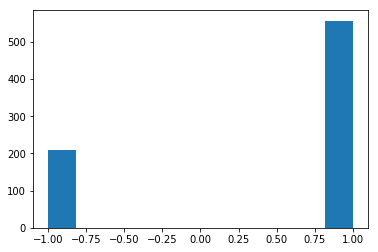

In [33]:
import matplotlib.pyplot as plt
from scipy import stats

pred = np.array([-clf2.estimator_weights_[0] if p != y_train[i] else clf2.estimator_weights_[0] for i, p in enumerate(clf2.estimators_[0].predict(X_train))])
margins = pred.reshape((-1, 1))

for i in range(1, len(clf2.estimators_)):
    pred = np.array([-clf2.estimator_weights_[i] if p != y_train[j] else clf2.estimator_weights_[i] for j, p in enumerate(clf2.estimators_[i].predict(X_train))])
    margins = np.concatenate((margins, pred.reshape(-1, 1)), axis=1)

marginss = np.sum(margins, axis=1)

#np.histogram(margins)
marginss = np.sum(margins, axis=1)
plt.hist(marginss, bins='auto')
print(stats.describe(marginss))